Model, Multi-Head Attention ile oluşturuluyor...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 120, 110)  │      3,410 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 60, 110)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 110)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn (TCN)           │ (None, 60, 75)    │    247,050 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 75)    │          0 │ tcn[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_0 (LSTM)       │ (None, 60, 84)    │     53,760 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm_0      │ (None, 60, 84)    │          0 │ lstm_0[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 84)    │     86,868 │ dropout_lstm_0[0… │
│ (MultiHeadAttentio… │                   │            │ dropout_lstm_0[0… │
│                     │                   │            │ dropout_lstm_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 84)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │      2,040 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 393,128 (1.50 MB)

 Trainable params: 393,128 (1.50 MB)

 Non-trainable params: 0 (0.00 B)


Model, nihai değerlendirme için eğitiliyor...
Epoch 1/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 61s 28ms/step - loss: 0.0218 - val_loss: 0.0114
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step - loss: 0.0118 - val_loss: 0.0104
Epoch 3/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 4/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 58s 27ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 5/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step - loss: 0.0097 - val_loss: 0.0090

--- Model Performansı (CNN + TCN + LSTM + Multi-Head Attention) ---
Test MSE :  83,346.36
Test RMSE:  288.70
Test MAE :  232.88
Test MAPE:  9.54%
Test R²  :  0.5629


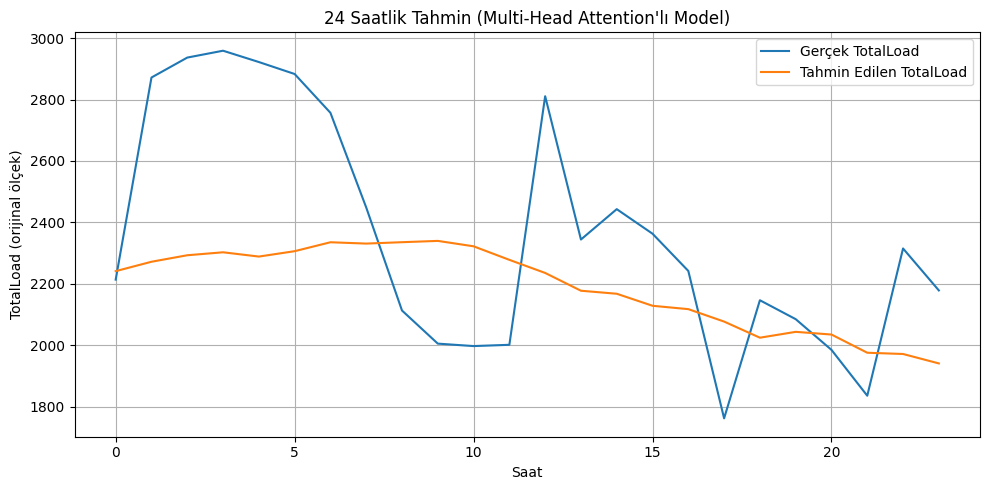

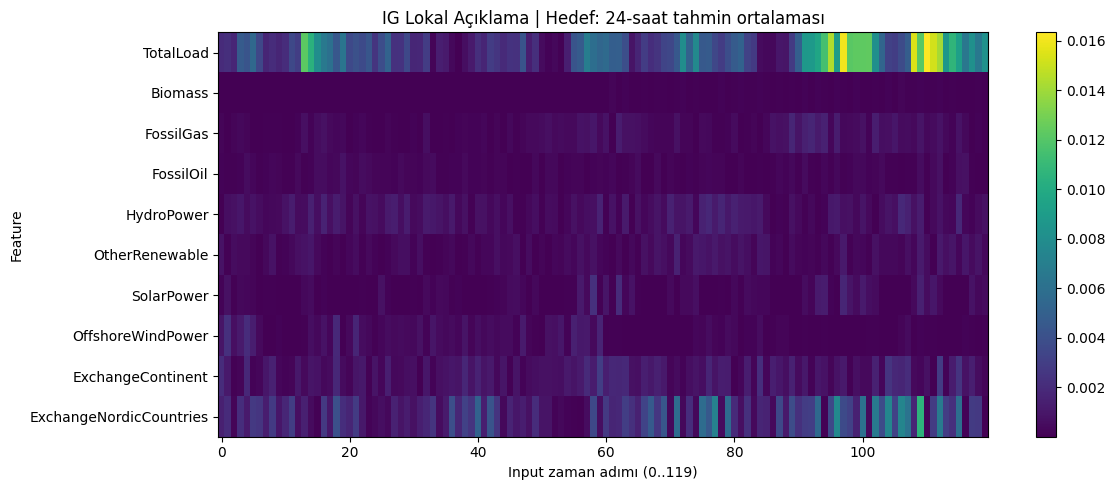

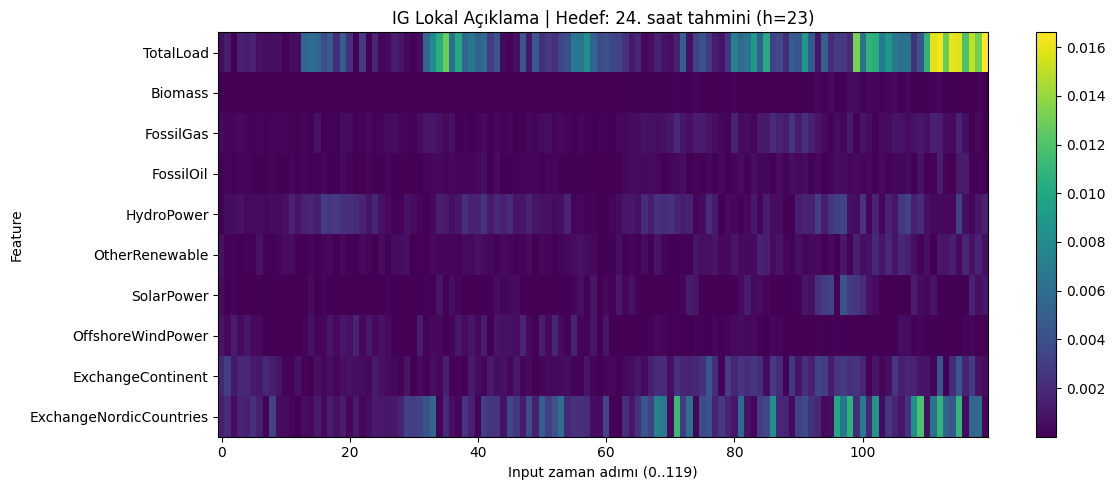

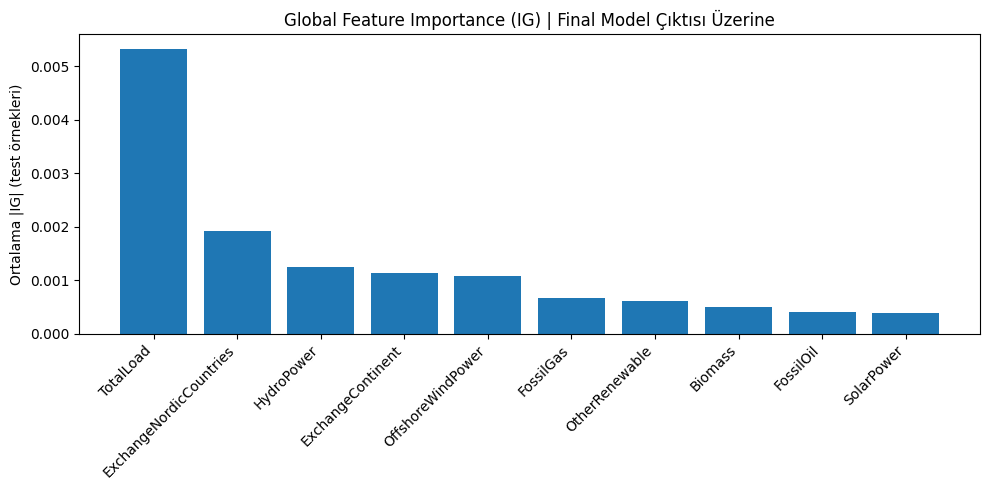

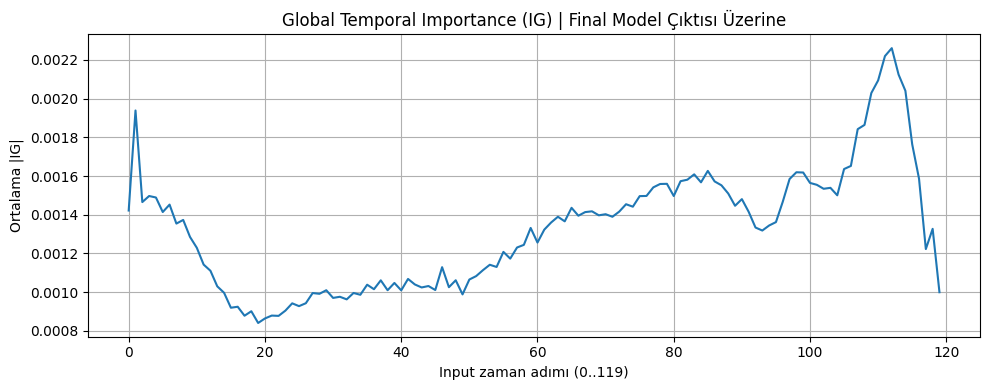

In [1]:
# ============================================================
# 🎯 Nihai Model Değerlendirme - Multi-Head Attention'lı Versiyon
# + XAI (Integrated Gradients) - Final Model Çıktısı Üzerine
# (FIXED) IG input shape: (m, 120, 10)  ✅
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# TCN
from tcn import TCN

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# === Sabitler ===
CSV_PATH = "clean-dataset.csv"
TARGET_COL = "TotalLoad"
INPUT_LEN = 120
OUTPUT_LEN = 24

SELECTED_COLS = ['TotalLoad', 'Biomass', 'FossilGas', 'FossilOil', 
                 'HydroPower', 'OtherRenewable', 'SolarPower', 
                 'OffshoreWindPower', 'ExchangeContinent', 'ExchangeNordicCountries']

# === Veri yükleme ===
try:
    df = pd.read_csv(CSV_PATH)
    df.columns = df.columns.str.strip()
except FileNotFoundError:
    print(f"HATA: '{CSV_PATH}' bulunamadı.")
    raise SystemExit

if "HourUTC" in df.columns:
    df["HourUTC"] = pd.to_datetime(df["HourUTC"], errors="coerce")
    df = df.sort_values("HourUTC").reset_index(drop=True)

# Ölçekleme
scalers = {}
cols_to_scale = list(set(SELECTED_COLS + [TARGET_COL]))
for col in cols_to_scale:
    if col in df.columns:
        sc = MinMaxScaler()
        df[col] = sc.fit_transform(df[[col]])
        scalers[col] = sc

# === Kayar pencere ===
def create_sliding_windows(
    df: pd.DataFrame,
    features: list,
    input_len=120,
    output_len=24,
    target_col="TotalLoad"
):
    data = df[features].values
    target = df[target_col].values

    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i + input_len])
        y.append(target[i + input_len:i + input_len + output_len])
    return np.array(X), np.array(y), features

feature_names = [col for col in SELECTED_COLS if col in df.columns]
X, y, features = create_sliding_windows(
    df, features=feature_names,
    input_len=INPUT_LEN, output_len=OUTPUT_LEN, target_col=TARGET_COL
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# === MAPE ===
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100


# ============================================================
# XAI: Integrated Gradients (Final model output üzerine) - FIXED
# ============================================================
def integrated_gradients(
    model,
    x,                         # (1, 120, 10)
    baseline=None,             # same shape
    target_mode="mean",        # "mean" or "step"
    target_step=0,             # 0..23
    m_steps=50
):
    x = tf.convert_to_tensor(x, dtype=tf.float32)              # (1,T,F)
    if baseline is None:
        baseline = tf.zeros_like(x)
    else:
        baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    # alphas: (m+1,) -> reshape to (m+1,1,1) for broadcast
    alphas = tf.linspace(0.0, 1.0, m_steps + 1)
    alphas = tf.reshape(alphas, (-1, 1, 1))

    # Convert (1,T,F) to (T,F) for interpolation
    x0 = baseline[0]     # (T,F)
    x1 = x[0]            # (T,F)

    # interpolated: (m+1, T, F)  ✅ matches model input (batch,120,10)
    interpolated = x0 + alphas * (x1 - x0)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated, training=False)            # (m+1, 24)

        if target_mode == "mean":
            target = tf.reduce_mean(preds, axis=1)             # (m+1,)
        elif target_mode == "step":
            target = preds[:, target_step]                     # (m+1,)
        else:
            raise ValueError("target_mode must be 'mean' or 'step'")

    grads = tape.gradient(target, interpolated)                # (m+1, T, F)

    # Trapezoidal approximation over alphas
    grads = (grads[:-1] + grads[1:]) / 2.0                     # (m, T, F)
    avg_grads = tf.reduce_mean(grads, axis=0)                  # (T, F)

    ig = (x1 - x0) * avg_grads                                 # (T, F)
    return ig.numpy()                                          # (120, 10)


def global_feature_importance_ig(model, X_data, n_samples=200, m_steps=30, seed=42):
    rng = np.random.default_rng(seed)
    n = min(n_samples, X_data.shape[0])
    idxs = rng.choice(X_data.shape[0], size=n, replace=False)

    feat_scores = np.zeros((X_data.shape[2],), dtype=np.float64)  # F
    time_scores = np.zeros((X_data.shape[1],), dtype=np.float64)  # T

    for i in idxs:
        x = X_data[i:i + 1]
        baseline = np.zeros_like(x)

        attr = integrated_gradients(
            model, x,
            baseline=baseline,
            target_mode="mean",
            m_steps=m_steps
        )  # (T, F)

        feat_scores += np.mean(np.abs(attr), axis=0)  # (F,)
        time_scores += np.mean(np.abs(attr), axis=1)  # (T,)

    feat_scores /= n
    time_scores /= n
    return feat_scores, time_scores


# === Optimum Parametreler (Multi-Head eklendi) ===
BEST_PARAMS = {
    'cnn_filters': 110,
    'cnn_kernel': 3,
    'cnn_dropout': 0.3675470566186519,
    'tcn_filters': 75,
    'tcn_kernel': 5,
    'tcn_dropout': 0.21991112627321538,
    'lstm_layers': 1,
    'lr': 0.000267740608371237,
    'batch_size': 16,
    'lstm_units_0': 84,
    'dropout_lstm_0': 0.1788371387484441,
    'num_heads': 8,
    'key_dim': 32
}

# === Model (CNN + TCN + LSTM + Multi-Head Attention) ===
print("Model, Multi-Head Attention ile oluşturuluyor...")
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN
x = Conv1D(
    BEST_PARAMS['cnn_filters'],
    kernel_size=BEST_PARAMS['cnn_kernel'],
    activation='relu',
    padding='same'
)(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(BEST_PARAMS['cnn_dropout'])(x)

# TCN
x = TCN(
    nb_filters=BEST_PARAMS['tcn_filters'],
    kernel_size=BEST_PARAMS['tcn_kernel'],
    dilations=[1, 2, 4, 8],
    activation='relu',
    return_sequences=True
)(x)
x = Dropout(BEST_PARAMS['tcn_dropout'])(x)

# LSTM blokları
for i in range(BEST_PARAMS['lstm_layers']):
    units = BEST_PARAMS[f'lstm_units_{i}']
    dropout_rate = BEST_PARAMS[f'dropout_lstm_{i}']
    x = LSTM(units, return_sequences=True, name=f'lstm_{i}')(x)
    x = Dropout(dropout_rate, name=f'dropout_lstm_{i}')(x)

# Multi-Head Self-Attention
attn_output = MultiHeadAttention(
    num_heads=BEST_PARAMS['num_heads'],
    key_dim=BEST_PARAMS['key_dim'],
)(
    query=x,
    value=x,
    key=x
)

# Pooling
x = GlobalAveragePooling1D()(attn_output)

# Output
outputs = Dense(OUTPUT_LEN)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=BEST_PARAMS['lr']), loss='mse')
model.summary()

# === Eğitim ===
print("\nModel, nihai değerlendirme için eğitiliyor...")
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=BEST_PARAMS['batch_size'],
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# === Tahmin ve ters ölçekleme ===
y_pred = model.predict(X_test, verbose=0)

tl_scaler = scalers[TARGET_COL]
y_test_inv = tl_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_inv = tl_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# === Metrikler ===
mse_inv = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
rmse_inv = np.sqrt(mse_inv)
r2_inv = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())
mae_inv = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
mape_inv = mean_absolute_percentage_error(y_test_inv.flatten(), y_pred_inv.flatten())

print(f"\n--- Model Performansı (CNN + TCN + LSTM + Multi-Head Attention) ---")
print(f"Test MSE :  {mse_inv:,.2f}")
print(f"Test RMSE:  {rmse_inv:,.2f}")
print(f"Test MAE :  {mae_inv:,.2f}")
print(f"Test MAPE:  {mape_inv:.2f}%")
print(f"Test R²  :  {r2_inv:.4f}")

# === Görselleştirme (tahmin) ===
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[0], label='Gerçek TotalLoad')
plt.plot(y_pred_inv[0], label='Tahmin Edilen TotalLoad')
plt.title("24 Saatlik Tahmin (Multi-Head Attention'lı Model)")
plt.xlabel('Saat')
plt.ylabel('TotalLoad (orijinal ölçek)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# XAI ÇALIŞTIRMA: Integrated Gradients
# ============================================================

# (A) Lokal açıklama: tek örnek (hedef: 24-saat ortalama)
idx = 0
x_sample = X_test[idx:idx + 1]          # (1,120,10)
baseline = np.zeros_like(x_sample)

attr_mean = integrated_gradients(
    model, x_sample, baseline=baseline,
    target_mode="mean", m_steps=50
)  # (120,10)

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(attr_mean).T, aspect='auto')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Input zaman adımı (0..119)")
plt.ylabel("Feature")
plt.title("IG Lokal Açıklama | Hedef: 24-saat tahmin ortalaması")
plt.colorbar()
plt.tight_layout()
plt.show()

# (B) Lokal açıklama: belirli ufuk (ör. 24. saat tahmini = index 23)
attr_step23 = integrated_gradients(
    model, x_sample, baseline=baseline,
    target_mode="step", target_step=23, m_steps=50
)

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(attr_step23).T, aspect='auto')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Input zaman adımı (0..119)")
plt.ylabel("Feature")
plt.title("IG Lokal Açıklama | Hedef: 24. saat tahmini (h=23)")
plt.colorbar()
plt.tight_layout()
plt.show()

# (C) Global açıklama: test setinden örnekleyerek feature/time importance
feat_imp, time_imp = global_feature_importance_ig(
    model, X_test, n_samples=200, m_steps=30, seed=SEED
)

# Feature importance bar plot
order = np.argsort(feat_imp)[::-1]
plt.figure(figsize=(10, 5))
plt.bar([feature_names[i] for i in order], feat_imp[order])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Ortalama |IG| (test örnekleri)")
plt.title("Global Feature Importance (IG) | Final Model Çıktısı Üzerine")
plt.tight_layout()
plt.show()

# Temporal importance plot
plt.figure(figsize=(10, 4))
plt.plot(time_imp)
plt.grid(True)
plt.xlabel("Input zaman adımı (0..119)")
plt.ylabel("Ortalama |IG|")
plt.title("Global Temporal Importance (IG) | Final Model Çıktısı Üzerine")
plt.tight_layout()
plt.show()


/Users/umutguler/fiyat_env_tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



SHAP Analizi başlatılıyor... (Bu işlem biraz zaman alabilir)


100%|██████████| 10/10 [07:21<00:00, 44.12s/it]


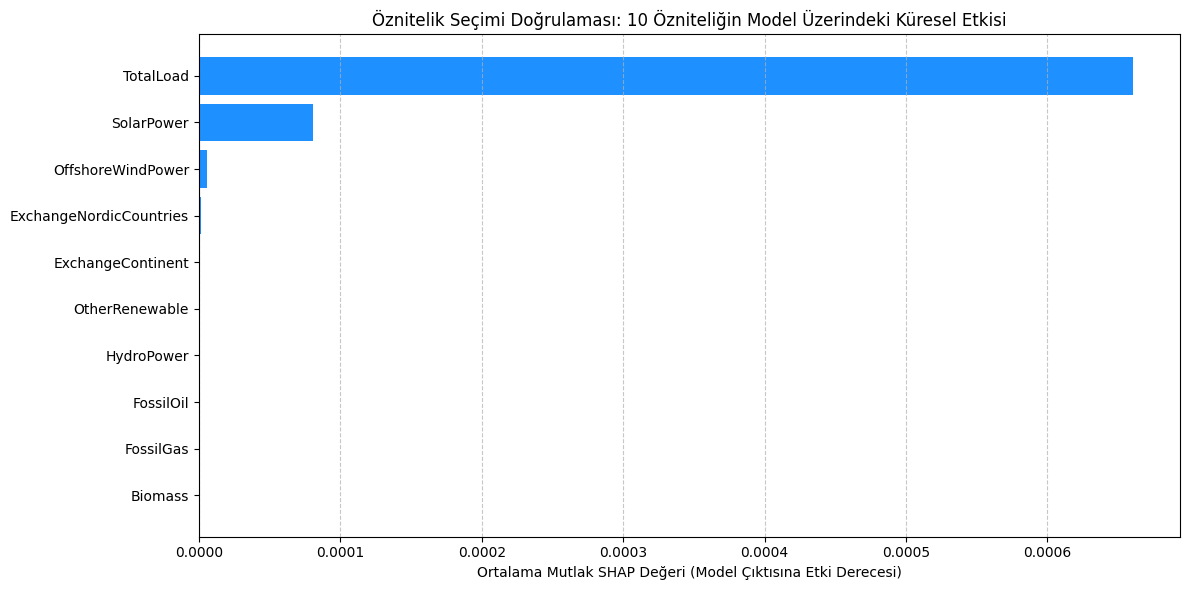

SHAP Summary Plot başarıyla oluşturuldu.


In [2]:
# ============================================================
# 🔍 SHAP XAI Analizi (KernelExplainer)
# ============================================================
import shap

print("\nSHAP Analizi başlatılıyor... (Bu işlem biraz zaman alabilir)")

# 1. SHAP için Wrapper (Sarmalayıcı) Fonksiyonu
# SHAP 2D veri gönderir, biz onu (örnek, 120, 10) formatına geri çeviriyoruz.
def shap_predict(x_flat):
    x_reshaped = x_flat.reshape((x_flat.shape[0], INPUT_LEN, len(feature_names)))
    preds = model.predict(x_reshaped, verbose=0)
    # Modelin çıktısı 24 saatliktir. SHAP genelde tek bir değer bekler. 
    # Global önem için 24 saatlik tahminin ortalamasını alıyoruz.
    return preds.mean(axis=1) 

# 2. Arka Plan (Background) Verisi Seçimi
# Hesaplamayı hızlandırmak için test setinden temsilci bir örneklem seçiyoruz.
X_test_flat = X_test.reshape(X_test.shape[0], -1)
background = shap.sample(X_test_flat, 20) # 20 örnek ideal hız sağlar

# 3. Explainer Oluşturma
explainer = shap.KernelExplainer(shap_predict, background)

# 4. SHAP Değerlerini Hesaplama
# İlk 10 test örneği üzerinde özniteliklerin etkisini hesaplayalım
num_test_samples = 10 
shap_values = explainer.shap_values(X_test_flat[:num_test_samples])

# 5. Görselleştirme: Global Feature Importance (Öznitelik Seçimi Doğrulaması)
# Zaman serisi verisinde her özelliğin her zaman adımındaki etkisini topluca görmek için:
# 120 zaman adımı x 10 özellik = 1200 kolon oluşur. 
# Biz bunu sadece 10 ana özellik bazında özetleyelim.

shap_values_reshaped = np.array(shap_values).reshape(num_test_samples, INPUT_LEN, len(feature_names))
# Zaman boyutu (axis=1) üzerinden mutlak değer ortalaması alarak 10 özniteliğe indirgeyelim
global_shap_importance = np.abs(shap_values_reshaped).mean(axis=(0, 1))

# Grafikleştirme
plt.figure(figsize=(12, 6))
indices = np.argsort(global_shap_importance)
plt.barh(range(len(indices)), global_shap_importance[indices], color='dodgerblue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Ortalama Mutlak SHAP Değeri (Model Çıktısına Etki Derecesi)')
plt.title('Öznitelik Seçimi Doğrulaması: 10 Özniteliğin Model Üzerindeki Küresel Etkisi')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("SHAP Summary Plot başarıyla oluşturuldu.")